In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import warnings
import itertools

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import GridSearchCV
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVR 
from sklearn.feature_selection import RFECV 

<h1> Cargando datos </h1>


In [2]:
semilla = pd.read_csv("seeds_dataset.csv")
#Informacion de los datos
print(semilla.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 9 columns):
Id                                  210 non-null int64
Area_A                              210 non-null float64
Perimetro_P                         210 non-null float64
Compacidad_C                        210 non-null float64
Longitud_del_grano                  210 non-null float64
Ancho_del_grano                     210 non-null float64
Coeficiente_de_asimetria            210 non-null float64
Longitud_de_la_ranura_del_nucleo    210 non-null float64
Tipo                                210 non-null object
dtypes: float64(7), int64(1), object(1)
memory usage: 14.9+ KB
None


<h1> Visualizando la distribución de clases</h1>


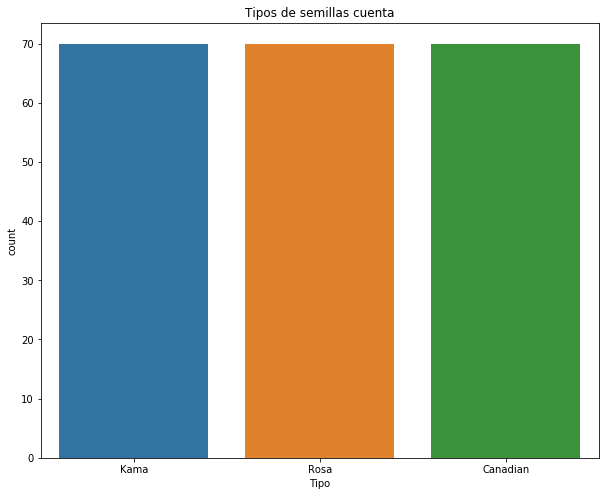

In [3]:
#Histograma del atributo clase
ax=plt.subplots(1,1,figsize=(10,8))
sns.countplot('Tipo',data=semilla)
plt.title("Tipos de semillas cuenta")
plt.show()

<h1>Visualizando los histogramas de los atributos </h1>

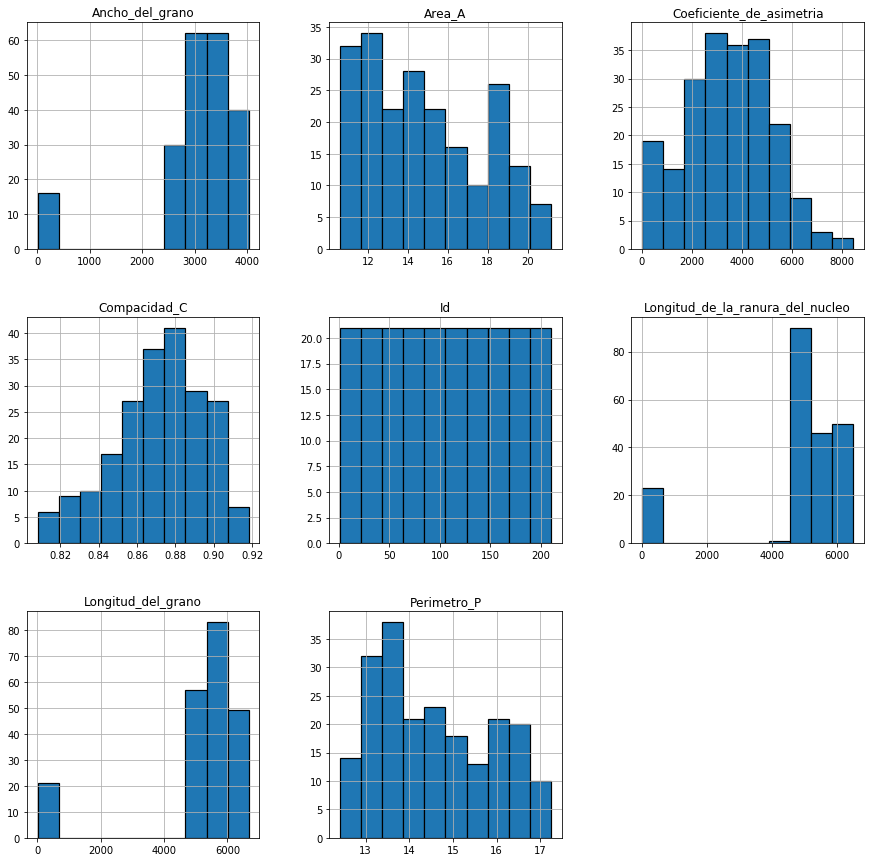

In [4]:
#Histograma de atributos predictores

semilla.hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(15,15)
plt.show()

<h1>Diagrama de cajas de los atributos o variables independientes.</h1>

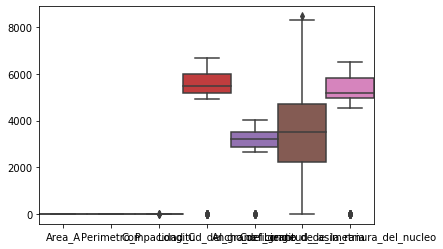

In [5]:
#boxplot de las variables numericas
semilla = semilla.drop('Id',axis=1)
box_data = semilla #variable representing the data array
box_target = semilla.Tipo #variable representing the labels array
sns.boxplot(data = box_data,width=1)
# sns.set(rc={'figure.figsize':(2,15)})
plt.show()

Observando la correlación entre variables permite descubrir posibles dependencias entre las variables independientes.

                                    Area_A  Perimetro_P  Compacidad_C  \
Area_A                            1.000000     0.994341      0.608288   
Perimetro_P                       0.994341     1.000000      0.529244   
Compacidad_C                      0.608288     0.529244      1.000000   
Longitud_del_grano                0.338719     0.348043      0.154178   
Ancho_del_grano                   0.407530     0.402118      0.316828   
Coeficiente_de_asimetria         -0.226488    -0.212141     -0.333325   
Longitud_de_la_ranura_del_nucleo  0.254070     0.252437      0.129848   

                                  Longitud_del_grano  Ancho_del_grano  \
Area_A                                      0.338719         0.407530   
Perimetro_P                                 0.348043         0.402118   
Compacidad_C                                0.154178         0.316828   
Longitud_del_grano                          1.000000         0.188229   
Ancho_del_grano                             0.1882

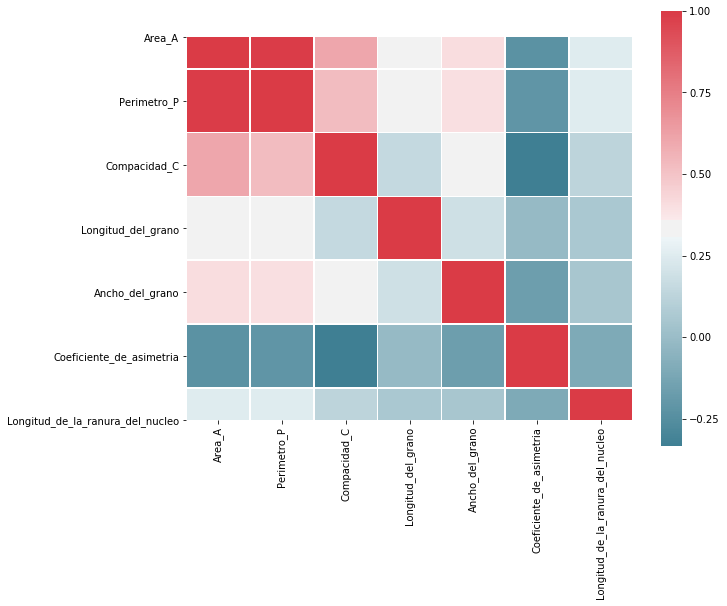

In [6]:
X = semilla.iloc[:, 0:7]
f, ax = plt.subplots(figsize=(10, 8))
corr = X.corr()
print(corr)
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
          cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, ax=ax, linewidths=.5)
plt.show() 

En la matriz de correlación se observa un alto coeficiente para las variables AreaA y PerimetroP. Podemos mirar el comportamiento de las dos variables utilizando regresión lineal.

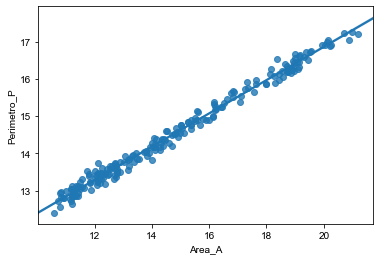

In [7]:
#observando relaciones entre los datos
sns.regplot(x='Area_A', y='Perimetro_P', data=semilla);
sns.set(rc={'figure.figsize':(20,5)})
plt.show()

Podemos observar, con la gráfica anterior el comportamiento casi lineal que tienen estas dos variables, por lo que podemos contemplar eliminar una de ambas para el entrenamiento y predicción del modelo, pero tendremos que realizar más análisis.

In [8]:
semilla = semilla.drop('Perimetro_P',axis=1)

In [9]:
semilla

,Area_A,Compacidad_C,Longitud_del_grano,Ancho_del_grano,Coeficiente_de_asimetria,Longitud_de_la_ranura_del_nucleo,Tipo
0,15.26,0.8710,5763.00,3312.0,2221.0,5.22,Kama
1,14.88,0.8811,5554.00,3333.0,1018.0,4956.00,Kama
2,14.29,0.9050,5291.00,3337.0,2699.0,4825.00,Kama
3,13.84,0.8955,5324.00,3379.0,2259.0,4805.00,Kama
4,16.14,0.9034,5658.00,3562.0,1355.0,5175.00,Kama
...,...,...,...,...,...,...,...
205,12.19,0.8783,5137.00,2981.0,3631.0,4.87,Canadian
206,11.23,0.8511,5.14,2795.0,4325.0,5003.00,Canadian
207,13.20,0.8883,5236.00,3232.0,8315.0,5056.00,Canadian
208,11.84,0.8521,5175.00,2836.0,3598.0,5044.00,Canadian


Una vez observado y analizado las variables del conjunto de datos vamos a hacer una primera prueba preliminar para observar cómo se comportaría el modelo de red neuronal. La configuración de este primer modelo se indica a través de los parámetros de MPLClassifier


In [10]:
#Separando los datos en conjuntos de entrenaimiento y prueba
X = semilla.iloc[:, :-1].values
y = semilla.iloc[:, 6].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

#Como esta es una primera prueba prelimintar coloco esta instrucción para que nos me saque un warning
#debido a que el modelo no alcanza a converger
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")

#Entrenando un modelo de red neuronal MLP para clasificación
#MLPClassifier permite configurar las capas ocultas del modelo, la instrucción de abajo indica que el modelo tendrá
#dos capas ocultas cada una con 3 neuronas. Algo como esto hidden_layer_sizes = (3,3,2) indicarían tres capas ocultas con
#3,3 y 2 neuronas respectivamente
model =  MLPClassifier(hidden_layer_sizes = (3,3,2), alpha=0.01, max_iter=1000) 
model.fit(X_train, y_train) #Training the model

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(3, 3, 2), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

Una vez entrenado el modelo, debemos evaluarlo sobre el conjunto de datos reservado para prueba, y utilizar algunas métricas para observar que tan bien quedo entrenado el modelo. En esta primera prueba utilizamos como métricas el porcentaje de precisión del modelo y la matriz de confusión.

In [11]:
#Test the model
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, predictions))

0.40476190476190477
Confusion matrix:
[[ 5  9  0]
 [ 1 12  0]
 [ 0 15  0]]


<h1>Busqueda de grilla </h1>

Ahora vamos a ajustar los parámetros del modelo utilizando GridSearch



In [12]:
parameters = {'activation': ['tanh','relu'],
              'solver': ['lbfgs','adam'], 
              'max_iter': [100,300,500], 
              'alpha': 10.0 ** -np.arange(3, 10), 
              'hidden_layer_sizes': [(3,3,2),(2,3,4), (3,2,2)],
              'random_state':[0,8,9]}

In [13]:
mlp1 = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1, cv=5)
mlp1.fit(X_train, y_train)
print(mlp1.score(X_train, y_train))
print(mlp1.best_params_) 

0.5
{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (3, 3, 2), 'max_iter': 100, 'random_state': 9, 'solver': 'adam'}


D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [14]:
print(mlp1.best_params_["activation"])

relu


<h1>Corrección del modelo</h1>

In [15]:
model =  MLPClassifier(solver = mlp1.best_params_["solver"], activation = mlp1.best_params_["activation"],  max_iter=mlp1.best_params_["max_iter"], random_state = mlp1.best_params_["random_state"] , alpha= mlp1.best_params_["alpha"], hidden_layer_sizes = mlp1.best_params_["hidden_layer_sizes"]) 
model.fit(X_train, y_train) #Training the model

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(3, 3, 2), learning_rate='constant',
              learning_rate_init=0.001, max_iter=100, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=9, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

Haciendo un test del modelo corregido

In [16]:
# #Test the model
predictions1 = model.predict(X_test)
print(accuracy_score(y_test, predictions1))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, predictions1))

0.5714285714285714
Confusion matrix:
[[14  0  0]
 [ 3 10  0]
 [10  5  0]]


In [17]:
from sklearn.model_selection import KFold
kf=KFold(n_splits=2, shuffle=True, random_state = 2)

df = pd.DataFrame(semilla)

for valores_x, valores_y in kf.split(X):
    print('Entrenamiento: ', df.iloc[valores_x], 'Prueba:',  df.iloc[valores_y] )


Entrenamiento:       Area_A  Compacidad_C  Longitud_del_grano  Ancho_del_grano  \
0     15.26        0.8710             5763.00          3312.00   
4     16.14        0.9034             5658.00          3562.00   
7     14.11        0.8911                5.42          3302.00   
15    14.59        0.8993             5351.00          3333.00   
16    13.99        0.9183             5119.00          3383.00   
..      ...           ...                 ...              ...   
204   12.37        0.8567             5204.00             2.96   
205   12.19        0.8783             5137.00          2981.00   
206   11.23        0.8511                5.14          2795.00   
208   11.84        0.8521             5175.00          2836.00   
209   12.30        0.8684             5243.00          2974.00   

     Coeficiente_de_asimetria  Longitud_de_la_ranura_del_nucleo      Tipo  
0                      2221.0                              5.22      Kama  
4                      1355.0          

In [18]:
class_names = semilla['Tipo'].unique()
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
def CalcularMatrizConfusion(y_test, y_pred):
       
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()


<h1>Matríz de confusión</h1>

Confusion matrix, without normalization
[[ 5  9  0]
 [ 1 12  0]
 [ 0 15  0]]
Normalized confusion matrix
[[0.36 0.64 0.  ]
 [0.08 0.92 0.  ]
 [0.   1.   0.  ]]


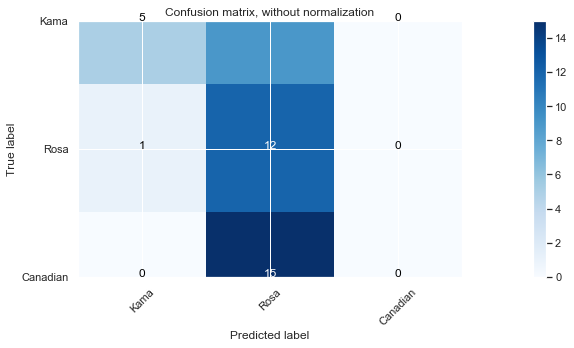

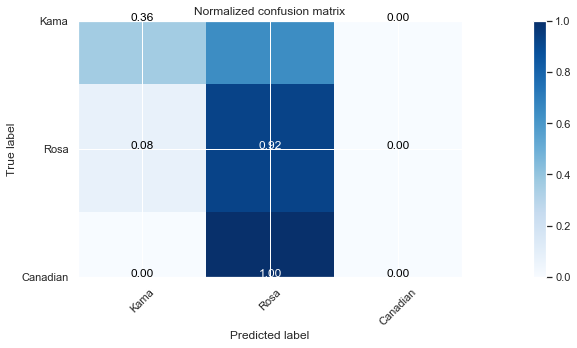

In [19]:
CalcularMatrizConfusion(y_test, predictions)